# Measuring Employee Attrition

The importance of data analytics is influencing the current HR sector. In times where specifially Generation Y and Z are characterised by their short-term engagements on different jobs, it is nowadays more important than ever to try to bind valauable employees on long-term to the company. This pehnomenom of job-hopping however is very complex which is why it is inevitable to understand the drivers that case a valuable employee to resign from their job. This notebook shall therefore utilize machine learning to predict which employyees are avout to resign from their job. This may help in determining if management should discuss new benefits or potential changes in the job if a valuable employee is about to quit. Additionally, it restricts management from investing into poorer performing employees that are about to resign anyway.

In [2]:
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Set Introduction and Cleaning

The utilized dataset to predict employee attrition is derived from Kaggle on shows generated data from IBM about HR Analytics in terms of employee attrition and performance. The fictional data contains information about education, job satisfaction, job involvement, environment satisfacion, performance rating, work life balance and relationship satisfaction.

In [3]:
df = pd.read_csv("HR.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Exploratory Data Analysis

[Text(0.5, 0, 'Department'), Text(0, 0.5, 'Count')]

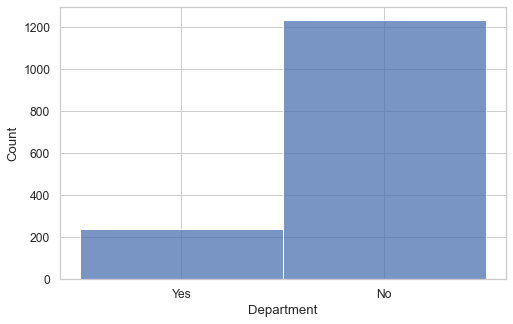

In [28]:
sns.set(style="whitegrid", palette="deep", font_scale=1.1, rc={"figure.figsize":[8,5]})
sns.histplot(df["Attrition"]).set(xlabel="Department", ylabel="Count")

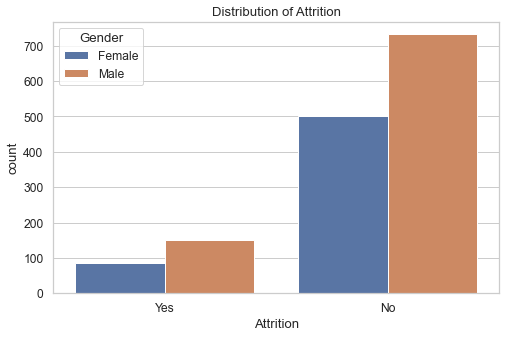

In [26]:
sns.countplot(x=df['Attrition'].dropna(), hue=df['Gender'].dropna())
plt.title('Distribution of Attrition')
plt.show()

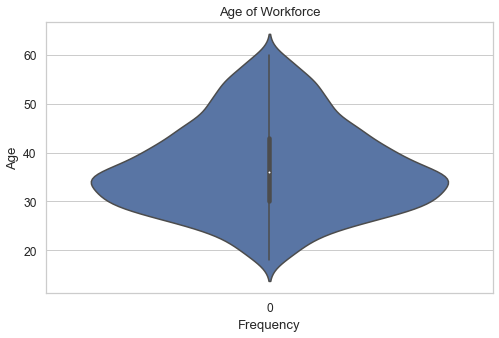

In [27]:
sns.violinplot(data=df["Age"])
plt.title('Age of Workforce')
plt.ylabel('Age')
plt.xlabel('Frequency')
plt.show()

In [5]:
df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

There are nearly 6x as many cases in which an employee is not abot to resign from their job which will make it difficult to predict a "Yes" instead of a "no". This model will therefore rely strongly on  precision/recall instead of accuracy. Given the above dpicted head of the dataset, the seven identified variables suitable for predicting attrition will be Distance from home, relationship satisfaction, total working years, training times last year, work life balance, years in company, years since last promotion. The data shall now be split into X and Y for the model.

## Splitting the Data

Following the Exploratory Data Analysis, I now want to prepare the data for the algorithm by splitting it. For the choice of variables used, the requirement according to the assignment was 7. Given my experience in business and logic, I argue that the Number of Companies worked should have an impact on how prone an employee is to resign again. Additionally Jopb Satisfaction usually has an impact as less happy employees are more likely to leave (If I would have more time I would enjoy proving these correlations and assumptions in the exploratory data analysis , but for some reason the way seaborn works here in jupyter notebooks for me is different from Visual Studio Code?!). Finally, Total Working Years seem interesting, as employees with a long time at the company might be less likeli to leave before retirement. 
Given the non-ninary nature of these variables such as Gender, Job Role, and Overtime, I need to create dummies. Whereas the difference in gender has been proven in the EDA, Job role could have an impact given that employees in lower levels might be more prone to leave. Over Time is known to cause stress, thus, reducing job satisfaction.

In [51]:
df2 = df[["Attrition","NumCompaniesWorked", "JobSatisfaction", "YearsAtCompany", "TotalWorkingYears"]]
dummies1 = pd.get_dummies(df["Gender"])
dummies2 = pd.get_dummies(df["JobRole"])
dummies3 = pd.get_dummies(df["OverTime"])
df3 = pd.concat([df2, dummies1, dummies2, dummies3], axis=1)
df3.head()

,Attrition,NumCompaniesWorked,JobSatisfaction,YearsAtCompany,TotalWorkingYears,Female,Male,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,No,Yes
0,Yes,8,4,6,8,1,0,0,0,0,0,0,0,0,1,0,0,1
1,No,1,2,10,10,0,1,0,0,0,0,0,0,1,0,0,1,0
2,Yes,6,3,0,7,0,1,0,0,1,0,0,0,0,0,0,0,1
3,No,1,3,8,8,1,0,0,0,0,0,0,0,1,0,0,0,1
4,No,9,2,2,6,0,1,0,0,1,0,0,0,0,0,0,1,0


In [54]:
X = df3[["NumCompaniesWorked","JobSatisfaction","YearsAtCompany","TotalWorkingYears", "Female", "Male", "Healthcare Representative", "Human Resources", "Laboratory Technician", "Manager", "Manufacturing Director", "Research Director", "Research Scientist", "Sales Executive","No","Yes"]]
y = df3['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.head()

,NumCompaniesWorked,JobSatisfaction,YearsAtCompany,TotalWorkingYears,Female,Male,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,No,Yes
99,4,2,3,17,0,1,0,0,1,0,0,0,0,0,1,0
785,4,4,11,14,0,1,1,0,0,0,0,0,0,0,1,0
918,4,2,29,31,0,1,0,0,0,1,0,0,0,0,0,1
1335,8,4,2,7,0,1,0,0,0,0,0,0,1,0,1,0
1182,0,3,3,4,1,0,0,0,0,0,1,0,0,0,1,0


### Training the Algorithm

Given the defined X and Y variables, the following step will be to train the algorithm. This works in a way in which the data is split into two different groups through the previous step. Whereas 70% of the data are evaluated and a considered the model, the remaining 30% are used to test the algorithm and how accurate the predictions are. The used method will be random forest. This classification algorithm consist of many decision trees that are build by randomness. Hence, an uncorrelates forest of trees whose prediction committee is more accurate than only one tree is created.

In [55]:
rf = RandomForestClassifier(random_state=1, n_estimators=100)
rf = rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.8231292517006803

### Evaluating the Model

The following step shall be used to analyse and evaluate the created model in terms of accuracy, preision, and recall using a confusion matrix.

In [56]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred) 
cm = pd.DataFrame(cm, index=['No Attrition (actual)', 'Attrition (actual)'], columns = ['No Attrition (pred)', 'Attrition (pred)']) #label and make df
cm

,No Attrition (pred),Attrition (pred)
No Attrition (actual),346,18
Attrition (actual),60,17


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.85      0.95      0.90       364
         Yes       0.49      0.22      0.30        77

    accuracy                           0.82       441
   macro avg       0.67      0.59      0.60       441
weighted avg       0.79      0.82      0.79       441



While the model is only reasonably accurate with a score of 0.82, specifically the prevision for attrition is insufficient with only 50%. This means that out of the low number of detected attrition cases, half of them were predicted wrongly. The recall rate is very bad as wel still miss 80% of attrition cases. 

## Conclusion

While prediction of attrition is a fairly difficult process given the subjectivity that is usually involved in tis process, the outcome of this model is insufficent. The model should therefore potentially set up again with a different set of variables, or perhaps a larger number of variables to account for the complexity involved in measuring attrition.